In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats
xr.set_options(keep_attrs=True)
import sys
sys.path.insert(1, './../')
import asym_funcs as af
import cartopy.crs as ccrs
import importlib
importlib.reload(af)

<module 'asym_funcs' from '/glade/u/home/lettier/analysis/analysis_temp-asym/pub/analysis/./../asym_funcs.py'>

In [11]:
ds = xr.open_dataset('../obsdata/daily_TREFHT_JRA55_1979-2018mean.nc')
ds = ds.where(abs(ds.lat)>20)
ds_f = af.xr_fourier_decomp (ds.dayofyear/len(ds.dayofyear), ds, 4, 'dayofyear')
a, t1 ,t2  =  af.asym_xr(ds_f,'dayofyear')
obds_j = -a.rename({'VAR_2T':'T_delta'})

In [12]:
ds = xr.open_dataset('../obsdata/daily_TREFHT_ERA5_1979-2018mean.nc')
ds = ds.where(abs(ds.lat)>20)
ds_f = af.xr_fourier_decomp (ds.dayofyear/len(ds.dayofyear), ds, 4, 'dayofyear')
a, t1 ,t2  =  af.asym_xr(ds_f,'dayofyear')
obds = -a.rename({'VAR_2T':'T_delta'})

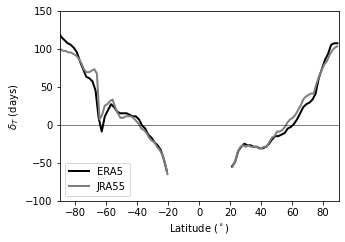

In [13]:
fig, ax = plt.subplots(1,figsize=(5,3.5))

obds.T_delta.plot(ax=ax,label='ERA5', linewidth=2, c='k')
(obds_j).T_delta.plot(ax=ax,label='JRA55', linewidth=2, c='tab:grey')

ax.set_title('')
ax.set_xlim([-90,90])
ax.set_ylim([-100,150])

ax.set_ylabel('$\delta_T$ (days)')
ax.set_xlabel('Latitude ($^\circ$)')
plt.legend()
ax.axhline(y=0,c='k',linewidth = 0.5)
fig.savefig('../figs/figS2.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

25 16 216 35.0
75 39 201 -41.0


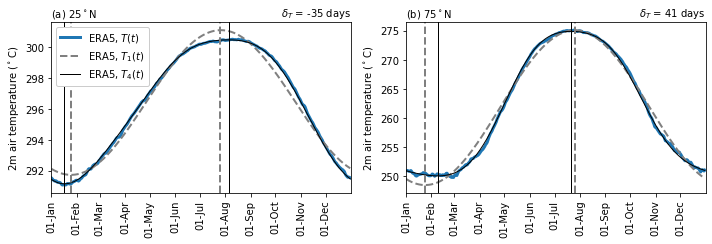

In [14]:
fig = plt.figure(figsize=(10,3.5))
for l, mylat in enumerate([25,75]):
    
    ax = plt.subplot(1,2,1+l) 
    myds = ds.interp(lat=mylat).rename({'dayofyear':'time'}).VAR_2T
    harm = af.get_annual_harmonic (myds.time.values/len(myds.time),myds.values)
    asymx, t1x ,t2x  =  af.asym_xr(ds_f.interp(lat=mylat).VAR_2T,'dayofyear')
    print(mylat, int(t1x), int(t2x), asymx.values)
    
    myds.plot(ax=ax, label='ERA5, $T(t)$',linewidth=3)
    ax.plot(myds.time.values, harm,linewidth=2,alpha=1.,linestyle='--',c='grey',label='ERA5, $T_1(t)$')
    ds_f.VAR_2T.interp(lat=mylat).plot(ax=ax, label='ERA5, $T_4(t)$',c='k',linewidth=1)
    
    ax.axvline(x=myds.time[int(t1x)],c='k',linewidth=1)
    ax.axvline(x=myds.time[int(t2x)],c='k',linewidth=1)
    ax.axvline(x=myds.time[np.argmin(harm)],linestyle='--',c='grey',alpha=1.,linewidth=2)
    ax.axvline(x=myds.time[np.argmax(harm)],linestyle='--',c='grey',alpha=1.,linewidth=2)

    ax.set_ylabel('2m air temperature ($^\circ$C)')
    ax.set_xticks(af.firstofmonthind )
    ax.set_xticklabels(af.firstofmonthlabel,rotation='vertical')
    ax.set_xlabel('')
    ax.set_xlim([1,366])
    ax.set_title('')
    ax.set_title(['(a) ','(b) '][l]+str(int(mylat))+'$^\circ$N',loc='left',fontsize=10)
    if l==0:
        plt.legend(facecolor='white', framealpha=1)
    ax.set_title('$\delta_T$ = {:d} days'.format(-int(asymx.values)),loc='right',fontsize=10)
plt.tight_layout()
fig.savefig('../figs/fig1.pdf',bbox_inches='tight')
plt.show()
plt.close()

In [15]:
def make_ds(a, t1, t2, method_name):
    
    for var in a:
        a = a.rename({var:var[5:]+'_delta'})
        t1 = t1.rename({var:var[5:]+'_t1'})
        t2 = t2.rename({var:var[5:]+'_t2'})
        ds = xr.merge([a, t1, t2])
        ds['names'] = 'ERA5_'+method_name
        ds = ds.set_coords('names')
        for var in ds:
            ds[var].attrs['units'] = 'd'
    return ds

In [16]:
ds = xr.open_dataset('../obsdata/daily_TREFHT_ERA5_1979-2018mean.nc')
ds = ds.where(abs(ds.lat)>20)

In [17]:
listds = []
for nmode in [ 2, 3, 4, 5, 6,  8, 10, 12,20]:
    a, t1 ,t2  =  af.asym_xr(af.xr_fourier_decomp (ds.dayofyear/len(ds.dayofyear), ds, nmode, 'dayofyear'),'dayofyear',tolerance = 0.0)
    listds.append(make_ds(a, t1, t2, 'fourier-'+str(nmode)+'modes'))

In [18]:
ds_test = xr.concat(listds,dim='names')

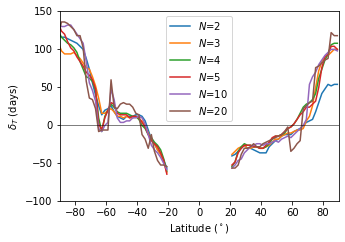

In [19]:
fig, ax = plt.subplots(1,figsize=(5,3.5))

for n, nmode in enumerate([2,3,4,5,10,20]):
        (-1.*ds_test.sel(names='ERA5_fourier-'+str(nmode)+'modes').T_delta).plot(ax=ax,label='$N$='+str(nmode))

ax.set_title('')
ax.set_xlim([-90,90])
ax.set_ylim([-100,150])
plt.legend()
ax.set_ylabel('$\delta_T$ (days)')
ax.set_xlabel('Latitude ($^\circ$)')
ax.axhline(y=0,c='k',linewidth = 0.5)
fig.savefig('../figs/figS1.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()